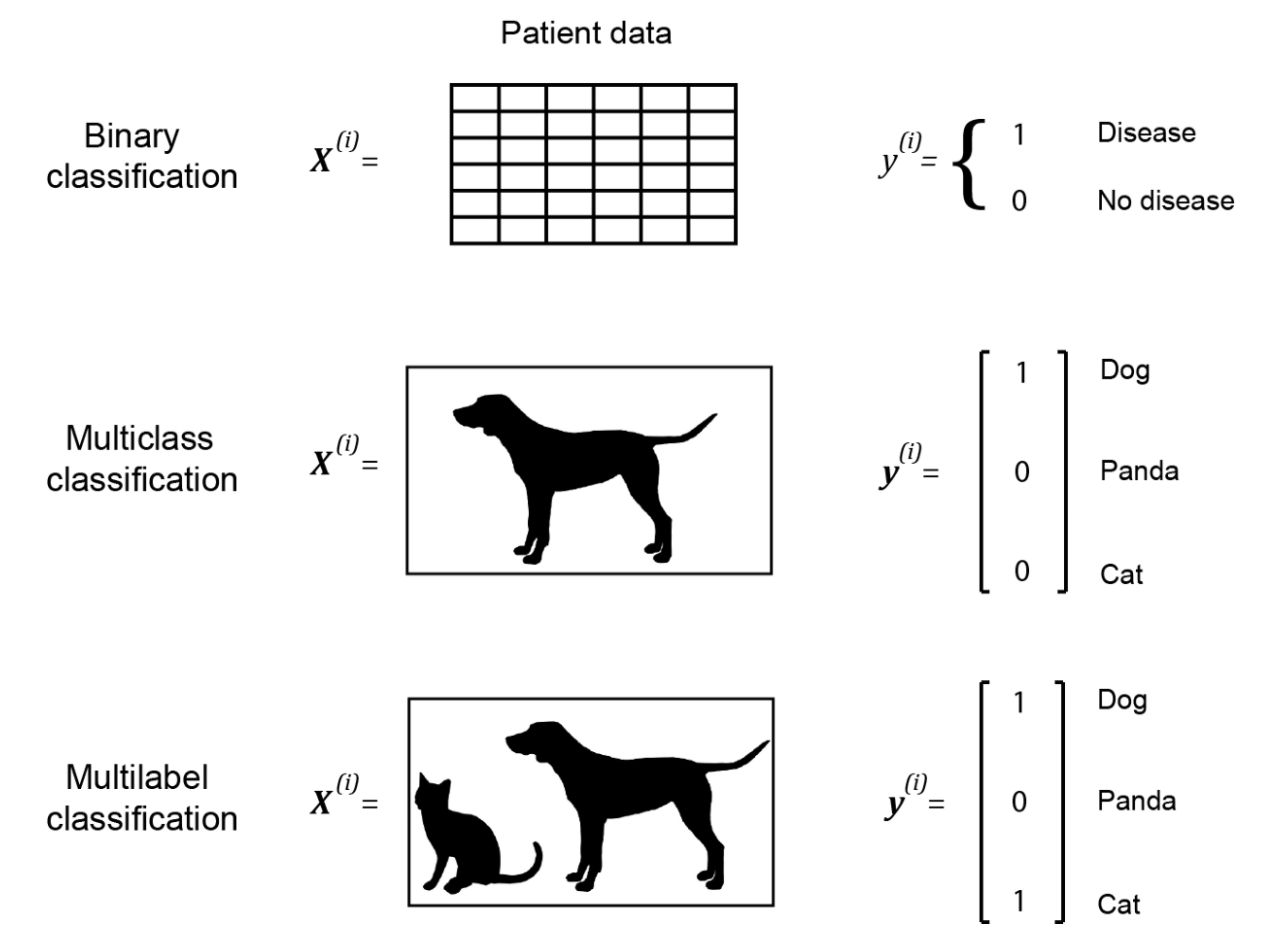

# Multiclass Classification

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import set_seeds, plot_decision_boundary, accuracy_fn, plot_predictions

In [2]:
CLASSES = 4
FEATURES = 2
SAMPLES = 1000

X_blob, y_blob = make_blobs(n_samples=SAMPLES,
                            n_features=FEATURES,
                            centers=CLASSES,
                            cluster_std=1.5,
                            random_state=42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_blob.to(device), y_blob.to(device), test_size=0.2, random_state=42)

y_train.shape, y_test.shape

(torch.Size([800]), torch.Size([200]))

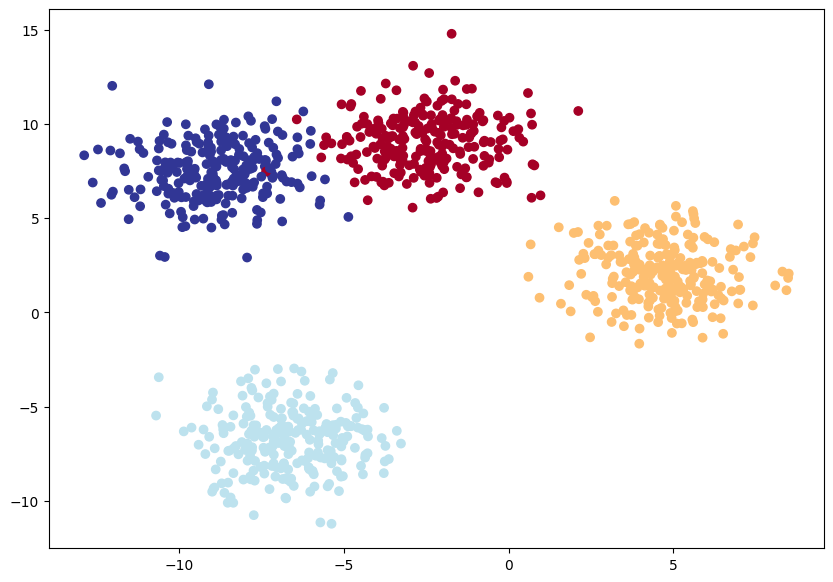

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='RdYlBu')

In [7]:
class MulticlassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super(MulticlassModel, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.linear_stack(x)
        

In [8]:
model = MulticlassModel(input_features=2,
                        output_features=4,
                        hidden_units=10)
model.to(device)

MulticlassModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [9]:
# plot_decision_boundary(model, X_train, y_train)

In [10]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [11]:
set_seeds()

epochs = 100

for epoch in range(epochs):
    model.train()

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    train_acc = accuracy_fn(y_train, torch.softmax(y_pred, 1).argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
            test_acc = accuracy_fn(y_test, torch.softmax(test_pred, 1).argmax(dim=1))
        print(f"Epoch: {epoch+1}, Train loss: {loss:.5f}, Train acc: {train_acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 10, Train loss: 0.91512, Train acc: 89.75%, Test loss: 0.86147, Test acc: 96.00%
Epoch: 20, Train loss: 0.35106, Train acc: 98.75%, Test loss: 0.32462, Test acc: 100.00%
Epoch: 30, Train loss: 0.14451, Train acc: 99.12%, Test loss: 0.13565, Test acc: 99.50%
Epoch: 40, Train loss: 0.08690, Train acc: 99.12%, Test loss: 0.07995, Test acc: 99.50%
Epoch: 50, Train loss: 0.06363, Train acc: 99.12%, Test loss: 0.05663, Test acc: 99.50%
Epoch: 60, Train loss: 0.05182, Train acc: 99.12%, Test loss: 0.04467, Test acc: 99.50%
Epoch: 70, Train loss: 0.04494, Train acc: 99.12%, Test loss: 0.03766, Test acc: 99.50%
Epoch: 80, Train loss: 0.04056, Train acc: 99.12%, Test loss: 0.03309, Test acc: 99.50%
Epoch: 90, Train loss: 0.03764, Train acc: 99.12%, Test loss: 0.02998, Test acc: 99.50%
Epoch: 100, Train loss: 0.03557, Train acc: 99.12%, Test loss: 0.02778, Test acc: 99.50%


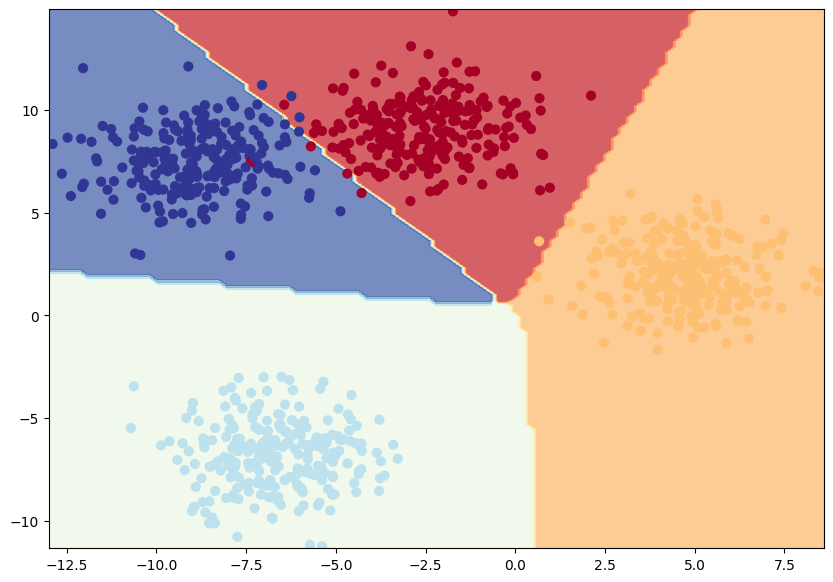

In [12]:
plt.figure(figsize=(10, 7))
plot_decision_boundary(model, X_blob, y_blob)

## Evaluate model

| Metric name/Evaluation method | Defintion | Code |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | torchmetrics.Accuracy() or sklearn.metrics.accuracy_score() |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | torchmetrics.Precision() or sklearn.metrics.precision_score() |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | torchmetrics.Recall() or sklearn.metrics.recall_score() |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | torchmetrics.F1Score() or sklearn.metrics.f1_score() |
| Confusion matrix | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix() |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | sklearn.metrics.classification_report() |

In [13]:
with torch.inference_mode():
    y_pred = torch.softmax(model(X_test.cpu()), 0).argmax(dim=1)

In [14]:
from torchmetrics import Accuracy

acc = Accuracy(task='multiclass', num_classes=4)
acc(y_pred.cpu(), y_test.cpu())

tensor(0.9950)